### Model visualization
Create visualizations for final XGBoost model and other model comparisons.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import calendar
import pickle
import time

%matplotlib inline
plt.style.use('seaborn-pastel')

import seaborn as sns
sns.set(style="whitegrid")

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from collections import defaultdict, Counter

%run evaluation_functions.py

In [5]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from lightgbm.sklearn import LGBMClassifier
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, 
                              AdaBoostClassifier, BaggingRegressor)

/Users/Jocelyn/anaconda3/envs/metis/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [6]:
with open("pickles/LR_model.pkl", "rb") as f:
    LR = pickle.load(f)
with open("pickles/RFC_model.pkl", "rb") as f:
    RFC = pickle.load(f)
with open("pickles/XGB_model.pkl", "rb") as f:
    XGB = pickle.load(f)
with open("pickles/LGB_model.pkl", "rb") as f:
    LGB = pickle.load(f)

In [7]:
with open("pickles/X_train.pickle", "rb") as f:
    X_train = pickle.load(f)
with open("pickles/y_train.pickle", "rb") as f:
    y_train = pickle.load(f)
with open("pickles/X_test.pickle", "rb") as f:
    X_test = pickle.load(f)
with open("pickles/y_test.pickle", "rb") as f:
    y_test = pickle.load(f)

In [8]:
X_cols = X_train.columns

In [9]:
#for final XGB model
with open("pickles/X2_train.pickle", "rb") as f:
    X2_train = pickle.load(f)
with open("pickles/y2_train.pickle", "rb") as f:
    y2_train = pickle.load(f)
with open("pickles/X2_test.pickle", "rb") as f:
    X2_test = pickle.load(f)
with open("pickles/y2_test.pickle", "rb") as f:
    y2_test = pickle.load(f)

In [10]:
X2_cols = X2_train.columns

### Compare Models

In [11]:
y_pred_prob_LR = LR.predict_proba(X_train)[:,1]
y_pred_prob_RFC = RFC.predict_proba(X_train)[:,1]
y_pred_prob_XGB = XGB.predict_proba(X2_train)[:,1]

In [12]:
print(f'LR o - v4: {roc_auc_score(y_train, y_pred_prob_LR):.3f}') # XGB
print(f'RFC o - v4: {roc_auc_score(y_train, y_pred_prob_RFC):.3f}') # XGB
print(f'XGB o - v4: {roc_auc_score(y2_train, y_pred_prob_XGB):.3f}') # XGB

LR o - v4: 0.628
RFC o - v4: 0.628
XGB o - v4: 0.666


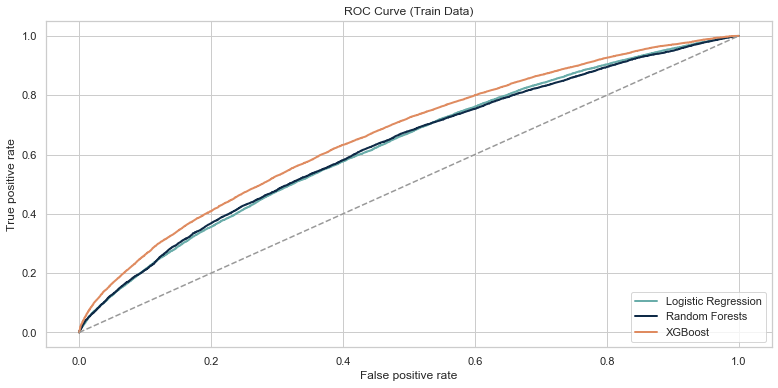

In [13]:
# Compare ROCs for:
fpr13, tpr13, thresholds13 = roc_curve(y_train, y_pred_prob_LR) # LR
fpr14, tpr14, thresholds14 = roc_curve(y_train, y_pred_prob_RFC) # RFC
fpr15, tpr15, thresholds15 = roc_curve(y2_train, y_pred_prob_XGB) # XGB


plt.figure(figsize=(13,6))

plt.plot(fpr13, tpr13,lw=2,label='Logistic Regression',c="#6aadaa")
plt.plot(fpr14, tpr14,lw=2,label='Random Forests',c="#0e2a47ff")
plt.plot(fpr15, tpr15,lw=2,label='XGBoost',c="#df8b60")
# plt.plot(fpr16, tpr16,lw=2,label='LGB o - v4')

plt.plot([0,1],[0,1],c='#999999',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.legend(loc='lower right')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve (Train Data)')

plt.savefig("figures/roc_model_compare.png", bbox_inches = 'tight');

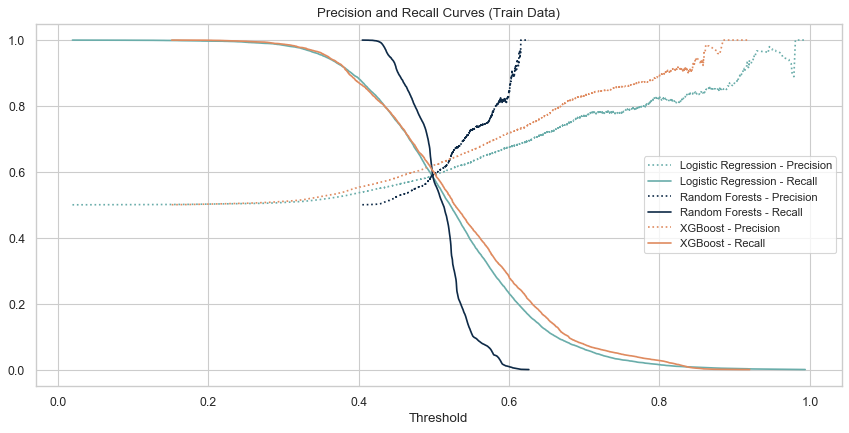

In [14]:
# Compare Precision/Recall curves
precision_curve2, recall_curve2, threshold_curve2 = precision_recall_curve(y_train, y_pred_prob_LR)
precision_curve4, recall_curve4, threshold_curve4 = precision_recall_curve(y_train, y_pred_prob_RFC)
precision_curve5, recall_curve5, threshold_curve5 = precision_recall_curve(y2_train, y_pred_prob_XGB)

plt.figure(dpi=80,figsize=(13,6))
plt.plot(threshold_curve2, precision_curve2[1:],label='Logistic Regression - Precision',color='#6aadaa',linestyle=':')
plt.plot(threshold_curve2, recall_curve2[1:], label='Logistic Regression - Recall',color='#6aadaa')
plt.plot(threshold_curve4, precision_curve4[1:],label='Random Forests - Precision',color='#0e2a47ff',linestyle=':')
plt.plot(threshold_curve4, recall_curve4[1:], label='Random Forests - Recall',color='#0e2a47ff')
plt.plot(threshold_curve5, precision_curve5[1:],label='XGBoost - Precision',color='#df8b60',linestyle=':')
plt.plot(threshold_curve5, recall_curve5[1:], label='XGBoost - Recall',color='#df8b60')
plt.legend(loc='center right',fontsize='small')
plt.xlabel('Threshold');
plt.title('Precision and Recall Curves (Train Data)')

plt.savefig("figures/p_r_model_compare.png", bbox_inches = 'tight');

### XGB models only (train and test)

In [15]:
y_test_pred_prob_XGB = XGB.predict_proba(X2_test)[:,1]
y_train_pred = XGB.predict(X2_train)
y_test_pred = XGB.predict(X2_test)

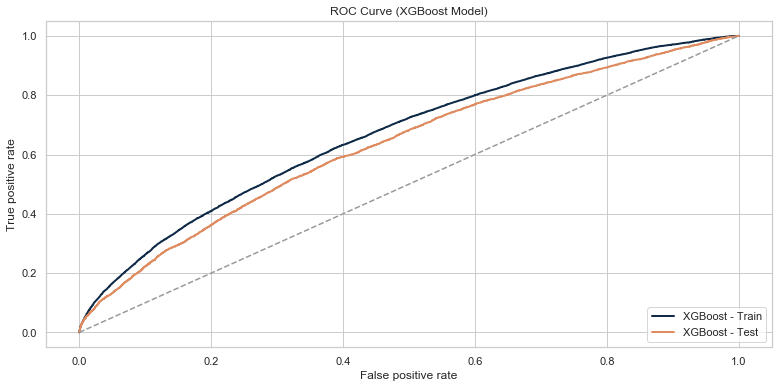

In [16]:
# Compare ROCs for:
# fpr13, tpr13, thresholds13 = roc_curve(y_train, y_pred_prob_LR) # LR
fpr14, tpr14, thresholds14 = roc_curve(y2_train, y_pred_prob_XGB) # RFC
fpr15, tpr15, thresholds15 = roc_curve(y2_test, y_test_pred_prob_XGB) # XGB

plt.figure(figsize=(13,6))

# plt.plot(fpr13, tpr13,lw=2,label='Logistic Regression',c="#6aadaa")
plt.plot(fpr14, tpr14,lw=2,label='XGBoost - Train',c="#0e2a47ff")
plt.plot(fpr15, tpr15,lw=2,label='XGBoost - Test',c="#df8b60")
# plt.plot(fpr16, tpr16,lw=2,label='LGB o - v4')

plt.plot([0,1],[0,1],c='#999999',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.legend(loc='lower right')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve (XGBoost Model)')

plt.savefig("figures/roc_XGB.png", bbox_inches = 'tight');

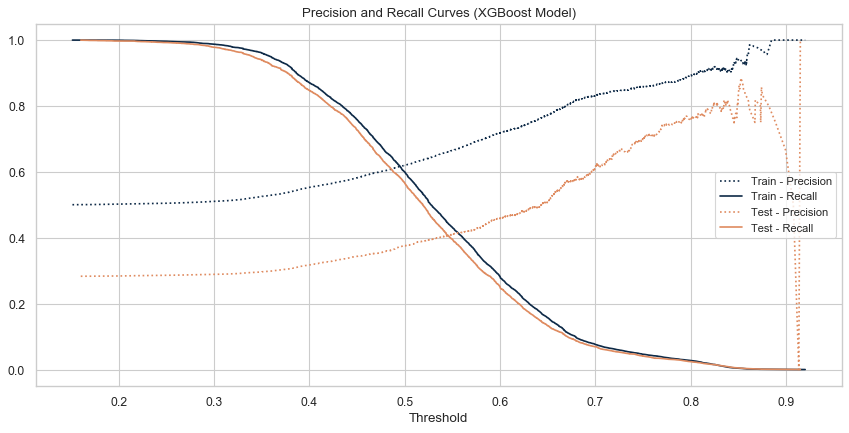

In [17]:

# Compare Precision/Recall curves
# precision_curve2, recall_curve2, threshold_curve2 = precision_recall_curve(y_train, y_pred_prob_LR)
precision_curve4, recall_curve4, threshold_curve4 = precision_recall_curve(y2_train, y_pred_prob_XGB)
precision_curve5, recall_curve5, threshold_curve5 = precision_recall_curve(y2_test, y_test_pred_prob_XGB)

plt.figure(dpi=80,figsize=(13,6))
# plt.plot(threshold_curve2, precision_curve2[1:],label='Logistic Regression - Precision',color='#6aadaa',linestyle=':')
# plt.plot(threshold_curve2, recall_curve2[1:], label='Logistic Regression - Recall',color='#6aadaa')
plt.plot(threshold_curve4, precision_curve4[1:],label='Train - Precision',color='#0e2a47ff',linestyle=':')
plt.plot(threshold_curve4, recall_curve4[1:], label='Train - Recall',color='#0e2a47ff')
plt.plot(threshold_curve5, precision_curve5[1:],label='Test - Precision',color='#df8b60',linestyle=':')
plt.plot(threshold_curve5, recall_curve5[1:], label='Test - Recall',color='#df8b60')
plt.legend(loc='center right',fontsize='small')
plt.xlabel('Threshold');
plt.title('Precision and Recall Curves (XGBoost Model)')

plt.savefig("figures/p_r_XGB.png", bbox_inches = 'tight');

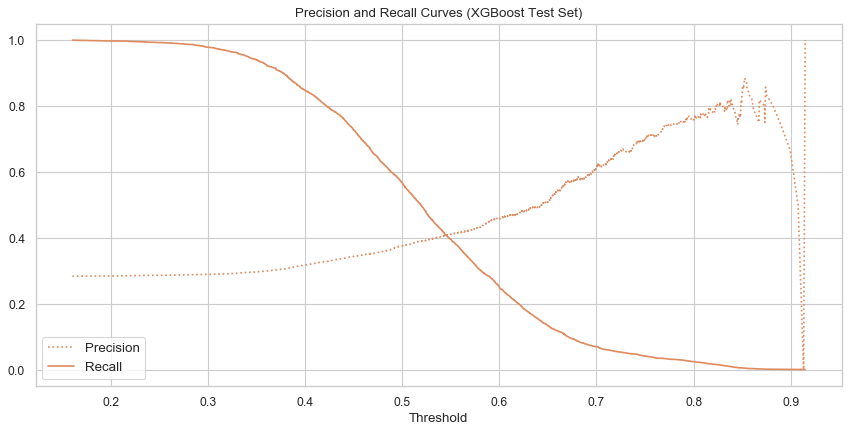

In [18]:
# Compare Precision/Recall curves
precision_curve5, recall_curve5, threshold_curve5 = precision_recall_curve(y2_test, y_test_pred_prob_XGB)

plt.figure(dpi=80,figsize=(13,6))
plt.plot(threshold_curve5, precision_curve5[1:],label='Precision',color='#df8b60',linestyle=':')
plt.plot(threshold_curve5, recall_curve5[1:], label='Recall',color='#df8b60')
plt.legend(loc='lower left',fontsize='medium')
plt.xlabel('Threshold');
plt.title('Precision and Recall Curves (XGBoost Test Set)')

plt.savefig("figures/p_r_XGB_test.png", bbox_inches = 'tight');

In [19]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
%run evaluation_functions.py

<Figure size 432x288 with 0 Axes>

In [20]:
# Print confusion matrix for logistic regression
logit_confusion_train = confusion_matrix(y2_train, y_train_pred)
logit_confusion_test = confusion_matrix(y2_test, y_test_pred)


print(logit_confusion_train)
print_scores(y2_train,y_train_pred)

[[24226 14050]
 [15312 22964]]
Accuracy score: 0.6164437245271188
F1 score: 0.6100146101739939
Precision (true + / all predicted +): 0.6204138974442103
Recall (true + / all actual +): 0.5999581983488348


In [21]:
print(logit_confusion_test)
print_scores(y2_test,y_test_pred)

[[8013 4746]
 [2183 2849]]
Accuracy score: 0.6105334157720196
F1 score: 0.45125524669359307
Precision (true + / all predicted +): 0.37511520737327186
Recall (true + / all actual +): 0.5661764705882353


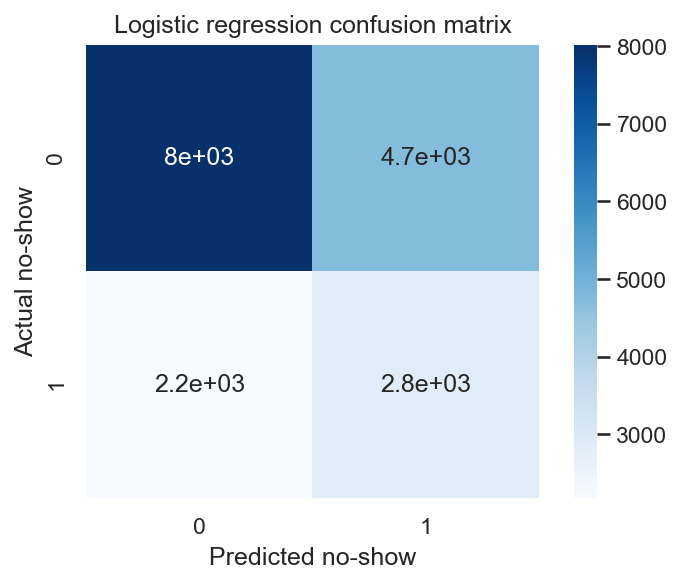

In [22]:
graph_conf_matrix(logit_confusion_test)

### Compare test performance for new patients vs not new patients

In [23]:
all_test = X2_test.copy()
all_test['target']=y2_test
all_test.head(5)

,Age2,Scholarship,Alcoholism,SMS_received,DayDiff2,Reschedule,Follow_up,prior_appt_count,prior_no_show_count,Neighbourhood2_ANDORINHAS,...,SchedDayofWeek_Friday,SchedDayofWeek_Saturday,SchedDayofWeek_Thursday,SchedDayofWeek_Tuesday,SchedDayofWeek_Wednesday,ApptDayofWeek_Friday,ApptDayofWeek_Thursday,ApptDayofWeek_Tuesday,ApptDayofWeek_Wednesday,target
46132,43,1,0,0,2,0,0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,1,1
35900,30,0,0,1,4,0,0,0.0,0.0,0,...,1,0,0,0,0,0,0,1,0,0
1446,73,0,0,0,1,0,0,0.0,0.0,1,...,0,0,1,0,0,1,0,0,0,0
62240,83,0,0,0,1,0,0,0.0,0.0,0,...,0,0,0,0,0,0,0,1,0,0
24175,16,0,0,0,4,0,0,1.0,0.0,0,...,1,0,0,0,0,0,0,1,0,0


In [24]:
new_test = all_test.loc[all_test['prior_appt_count']==0]
exs_test = all_test.loc[all_test['prior_appt_count']>0]

In [25]:
new_test.shape

(11397, 83)

In [26]:
exs_test.shape

(6394, 83)

In [27]:
X_test_new, y_test_new = new_test.drop(['target'],axis=1),new_test['target']
X_test_exs, y_test_exs = exs_test.drop(['target'],axis=1),exs_test['target']

In [28]:
y_test_new_prob = XGB.predict_proba(X_test_new)[:,1]
y_test_exs_prob = XGB.predict_proba(X_test_exs)[:,1]
y_test_all_prob = XGB.predict_proba(X2_test)[:,1]

In [29]:
print(f'AUC New: {roc_auc_score(y_test_new, y_test_new_prob):.3f}') 
print(f'AUC Old: {roc_auc_score(y_test_exs, y_test_exs_prob):.3f}') 
print(f'AUC All: {roc_auc_score(y2_test, y_test_all_prob):.3f}') 

AUC New: 0.610
AUC Old: 0.669
AUC All: 0.633


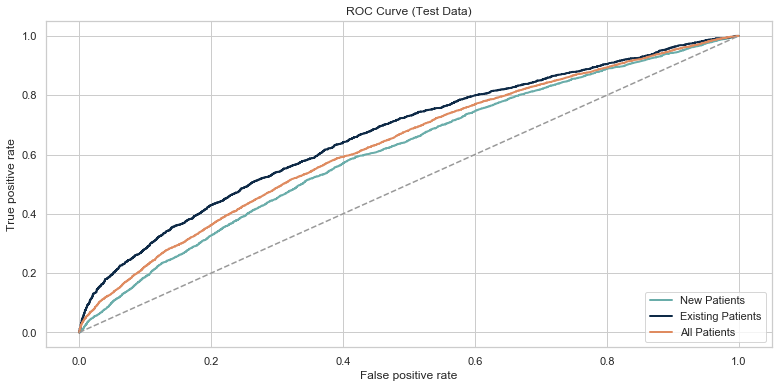

In [30]:
# Compare ROCs for:
fpr13, tpr13, thresholds13 = roc_curve(y_test_new, y_test_new_prob) # new
fpr14, tpr14, thresholds14 = roc_curve(y_test_exs, y_test_exs_prob) # exs
fpr15, tpr15, thresholds15 = roc_curve(y2_test, y_test_all_prob) # exs


plt.figure(figsize=(13,6))

plt.plot(fpr13, tpr13,lw=2,label='New Patients',c="#6aadaa")
plt.plot(fpr14, tpr14,lw=2,label='Existing Patients',c="#0e2a47ff")
plt.plot(fpr15, tpr15,lw=2,label='All Patients',c="#df8b60")
# plt.plot(fpr16, tpr16,lw=2,label='LGB o - v4')

plt.plot([0,1],[0,1],c='#999999',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.legend(loc='lower right')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve (Test Data)')

plt.savefig("figures/roc_new_exs.png", bbox_inches = 'tight');

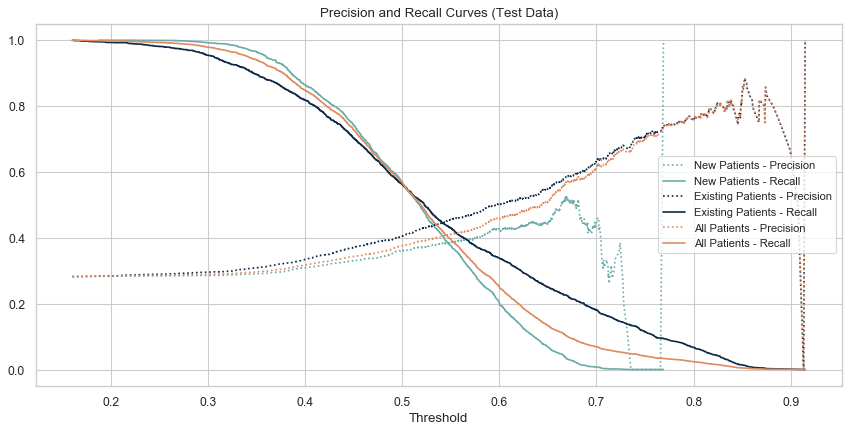

In [31]:
# Compare Precision/Recall curves
precision_curve2, recall_curve2, threshold_curve2 = precision_recall_curve(y_test_new, y_test_new_prob)
precision_curve4, recall_curve4, threshold_curve4 = precision_recall_curve(y_test_exs, y_test_exs_prob)
precision_curve5, recall_curve5, threshold_curve5 = precision_recall_curve(y2_test, y_test_all_prob)

plt.figure(dpi=80,figsize=(13,6))
plt.plot(threshold_curve2, precision_curve2[1:],label='New Patients - Precision',color='#6aadaa',linestyle=':')
plt.plot(threshold_curve2, recall_curve2[1:], label='New Patients - Recall',color='#6aadaa')
plt.plot(threshold_curve4, precision_curve4[1:],label='Existing Patients - Precision',color='#0e2a47ff',linestyle=':')
plt.plot(threshold_curve4, recall_curve4[1:], label='Existing Patients - Recall',color='#0e2a47ff')
plt.plot(threshold_curve5, precision_curve5[1:],label='All Patients - Precision',color='#df8b60',linestyle=':')
plt.plot(threshold_curve5, recall_curve5[1:], label='All Patients - Recall',color='#df8b60')
plt.legend(loc='center right',fontsize='small')
plt.xlabel('Threshold');
plt.title('Precision and Recall Curves (Test Data)')

plt.savefig("figures/p_r_new_exs.png", bbox_inches = 'tight');

### Visualizations

In [32]:
LR.feature_names = X_train.columns
# LR.target_names = list(np.unique(y_train))
LR.target_names = [1,0]

In [33]:
#Logistic Regression coefficients
def plot_ovr_coefs(model):
    """Helper to plot coefficients of a ovr model like Logistic Regression"""
    n_models, n_coef = model.coef_.shape

    lod = []
    for i in range(n_models):
        for j in range(n_coef):
            lod.append({
                "OVR Model": f"{model.target_names[i]} vs rest",
                "Coefficient Name": f"{model.feature_names[j]}",
                "Coefficient Value": model.coef_[i,j]
            })
    coef_df = pd.DataFrame(lod).sort_values('Coefficient Value',ascending=False)
#     return coef_df.head(5)
    plt.figure(figsize=(15,15))
    sns.barplot(y="Coefficient Name", x="Coefficient Value", hue="OVR Model", orient="h", data=coef_df)
    return coef_df

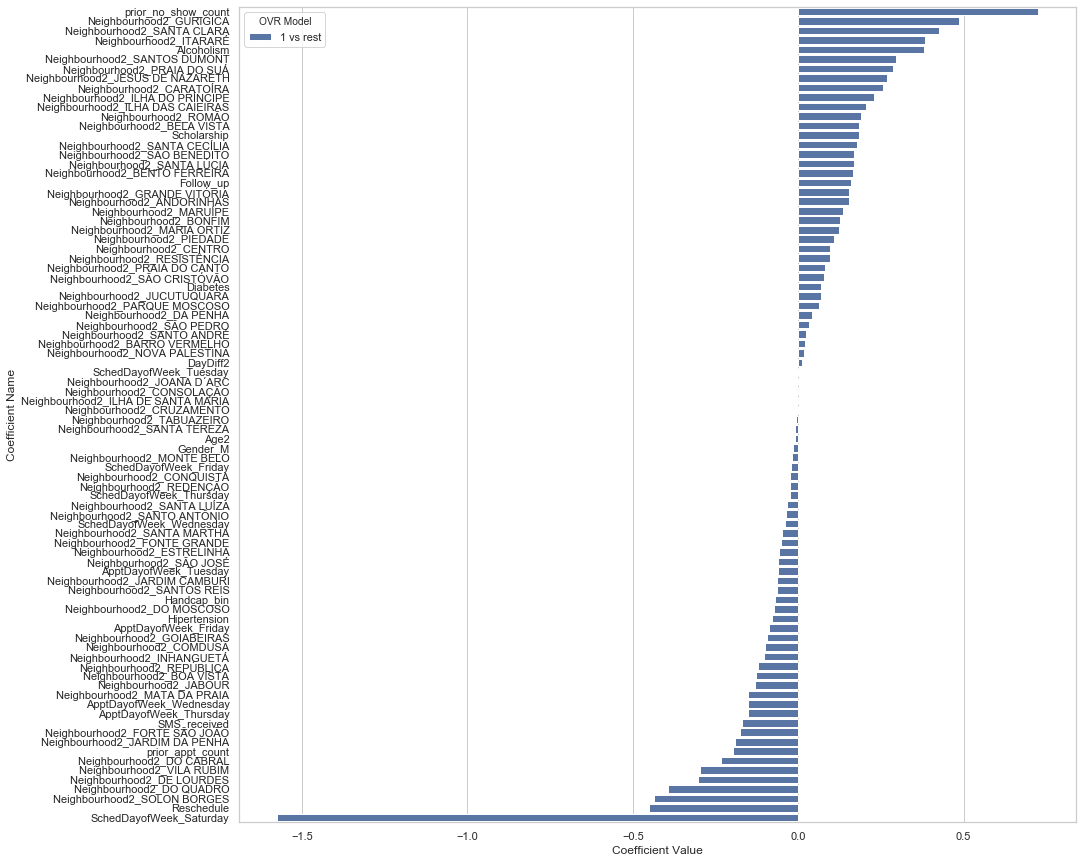

In [34]:
# let's plot the coefficients to demonstrate that the model and what it has learned are preserved through pickling
LR_df = plot_ovr_coefs(LR)

In [35]:
LR_df['test']= [x[0:14] != 'Neighbourhood2' for x in LR_df['Coefficient Name']]
LR_df2 = LR_df[['OVR Model','Coefficient Name','Coefficient Value']].loc[LR_df['test']]
LR_df2['Coefficients'] = ['Prior No-Show Count','Alcoholism','Public Assistance','Follow-Up','Diabetes',
                          'Days btwn Sched/Appt','Scheduled on a Tuesday','Age','Gender','Scheduled on a Friday',
                          'Scheduled on a Thursday','Scheduled on a Wednesday','Tuesday Appointment',
                          'Handicap/Disability','Hypertension','Friday Appointment','Wednesday Appointment',
                          'Thursday Appointment','Receives SMS','Prior Appointment Count',
                          'Reschedule','Scheduled on a Saturday'
                          ] 
LR_df2

,OVR Model,Coefficient Name,Coefficient Value,Coefficients
11,1 vs rest,prior_no_show_count,0.724750,Prior No-Show Count
4,1 vs rest,Alcoholism,0.381148,Alcoholism
1,1 vs rest,Scholarship,0.183305,Public Assistance
9,1 vs rest,Follow_up,0.158833,Follow-Up
3,1 vs rest,Diabetes,0.070013,Diabetes
7,1 vs rest,DayDiff2,0.011013,Days btwn Sched/Appt
80,1 vs rest,SchedDayofWeek_Tuesday,0.002525,Scheduled on a Tuesday
0,1 vs rest,Age2,-0.008927,Age
12,1 vs rest,Gender_M,-0.015810,Gender
77,1 vs rest,SchedDayofWeek_Friday,-0.022932,Scheduled on a Friday


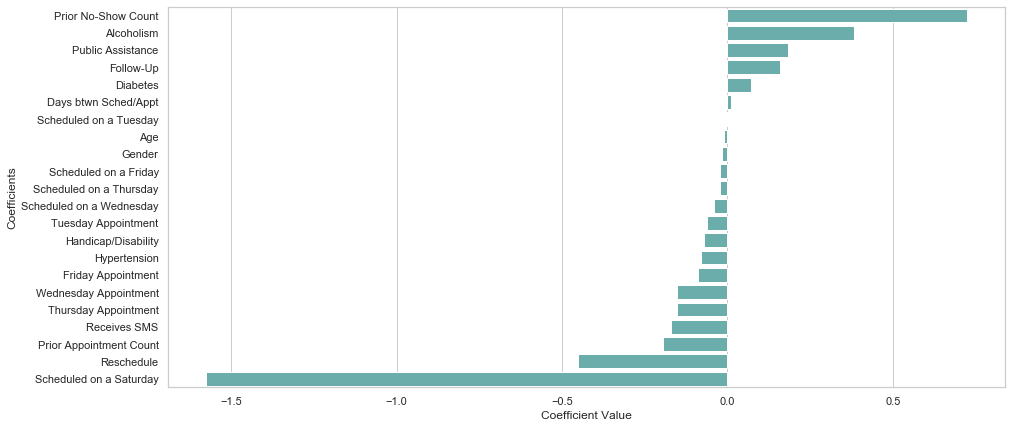

In [36]:
plt.figure(figsize=(15,7))
sns.barplot(y="Coefficients", x="Coefficient Value", orient="h", data=LR_df2,
            color='#6aadaa',saturation=1)

plt.savefig("figures/LR_coefs.png", bbox_inches = 'tight');

In [37]:
# plot feature importance

XGB.feature_names = X2_train.columns
XGB.target_names = [1,0]

def plot_ovr_fi(model):
    """Helper to plot feature importances"""
    
    n_fi = model.feature_importances_.shape[0]

    lod = []
    for j in range(n_fi):
        lod.append({
            "OVR Model": f"{model.target_names[0]} vs rest",
            "Feature Name": f"{model.feature_names[j]}",
            "Feature Importance Value": model.feature_importances_[j]
        })
    fi_df = pd.DataFrame(lod).sort_values('Feature Importance Value',ascending=False)
#     return coef_df.head(5)
    plt.figure(figsize=(15,15))
    sns.barplot(y="Feature Name", x="Feature Importance Value", hue="OVR Model", orient="h", data=fi_df)
    return fi_df

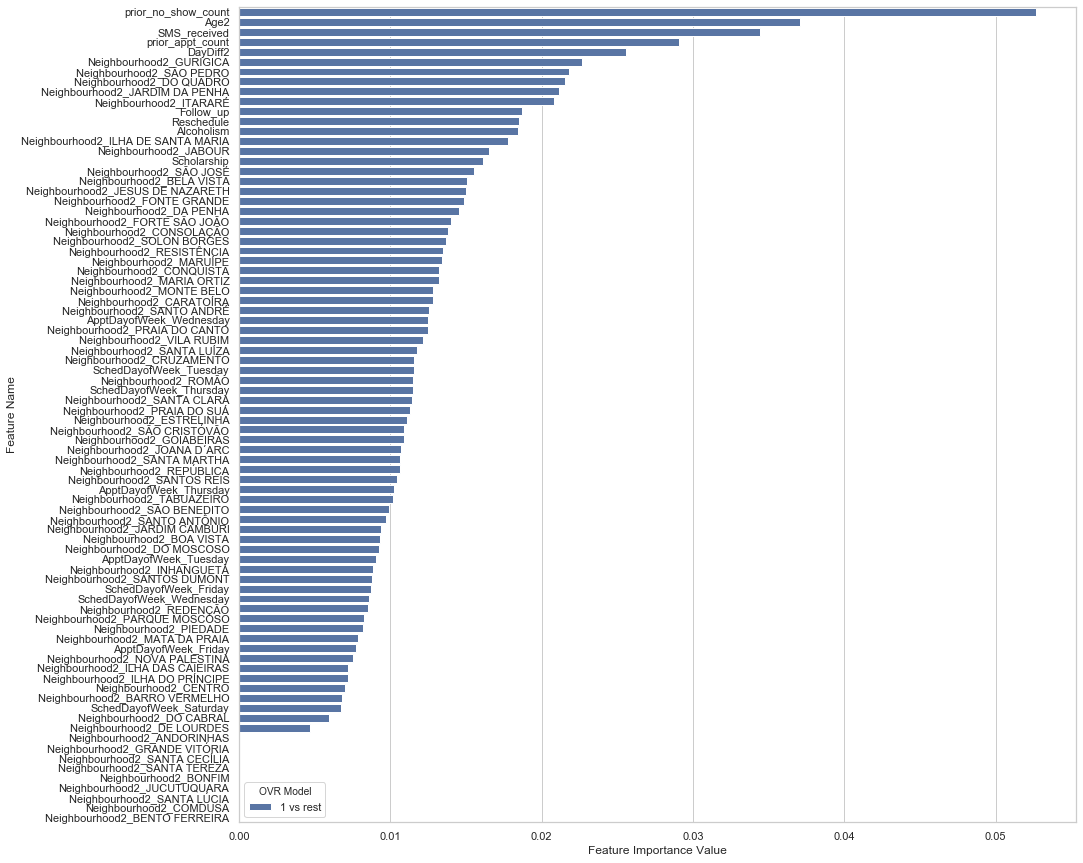

In [38]:
XGB_df = plot_ovr_fi(XGB)

In [46]:
XGB_df['test']= [x[0:14] != 'Neighbourhood2' for x in XGB_df['Feature Name']]
XGB_df2 = XGB_df[['OVR Model','Feature Name','Feature Importance Value']].loc[XGB_df['test']]
#clean columns
XGB_df2['Features'] = ['Prior No-Show Count','Age','Receives SMS','Prior Appointment Count','Days btwn Sched/Appt',
                          'Follow-Up','Reschedule','Alcoholism','Public Assistance','Wednesday Appointment',
                          'Scheduled on a Tuesday','Scheduled on a Thursday','Thursday Appointment',
                           'Tuesday Appointment','Scheduled on a Friday','Scheduled on a Wednesday',
                           'Friday Appointment','Scheduled on a Saturday'
                          ] 
XGB_df2[:9]

,OVR Model,Feature Name,Feature Importance Value,Features
8,1 vs rest,prior_no_show_count,0.052672,Prior No-Show Count
0,1 vs rest,Age2,0.037096,Age
3,1 vs rest,SMS_received,0.034412,Receives SMS
7,1 vs rest,prior_appt_count,0.029071,Prior Appointment Count
4,1 vs rest,DayDiff2,0.025593,Days btwn Sched/Appt
6,1 vs rest,Follow_up,0.018735,Follow-Up
5,1 vs rest,Reschedule,0.018483,Reschedule
2,1 vs rest,Alcoholism,0.018443,Alcoholism
1,1 vs rest,Scholarship,0.016109,Public Assistance


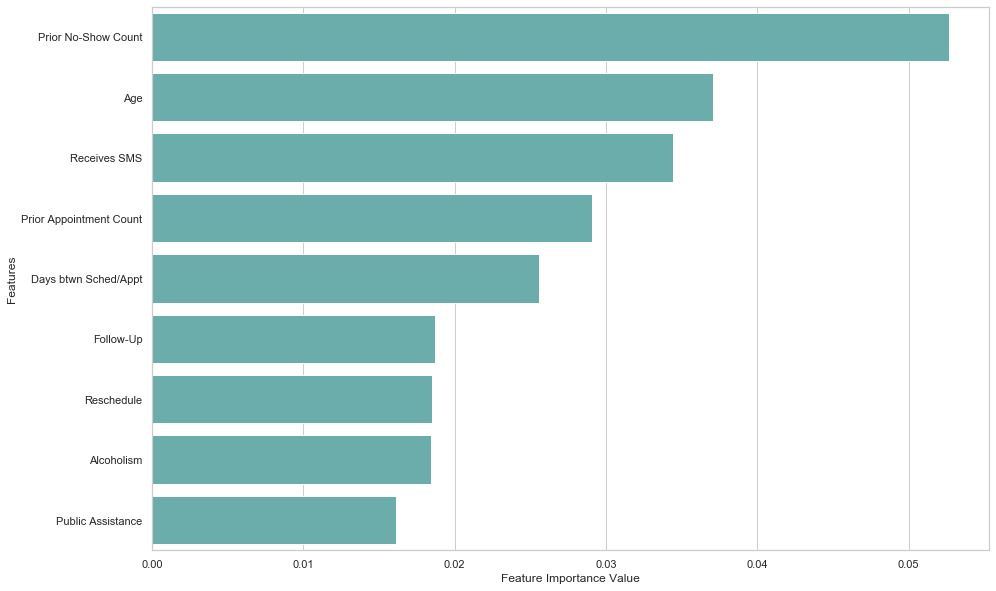

In [47]:
plt.figure(figsize=(15,10))
sns.barplot(y="Features", x="Feature Importance Value", orient="h", data=XGB_df2[:9],
           color='#6aadaa',saturation=1)

plt.savefig("figures/XGB_feature_importance.png", bbox_inches = 'tight');

### Decision Tree

In [41]:
decisiontree = DecisionTreeClassifier()
decisiontree.fit(X2_train,y2_train)
y_pred_DTC = decisiontree.predict(X2_test)

In [42]:
print_scores(y2_test,y_pred_DTC)

Accuracy score: 0.626833792366927
F1 score: 0.34390750074118
Precision (true + / all predicted +): 0.34204835856103794
Recall (true + / all actual +): 0.34578696343402227


In [43]:
# from sklearn.externals.six import StringIO  
# from IPython.display import Image  
# from sklearn.tree import export_graphviz
# import pydotplus

# dot_data = StringIO()

# export_graphviz(decisiontree, out_file=dot_data,  
#                 filled=True, rounded=True,
#                 special_characters=True)
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# # Image(graph.create_png())

In [44]:
# type(graph)

In [45]:
# Image(graph.create_png())